In [1]:
#Įsikeliame reikalingas bibliotekas
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import keras

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import LearningRateScheduler

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

import pickle
import os
import cv2
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# generatoriaus klasė
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # Konvertuojam paveikslėlį
            img = cv2.imread(ID)
            img = cv2.resize(img, (self.dim[0], self.dim[0]))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = np.expand_dims(img, axis=-1)
            X[i,] = img / 255

            # Store class
            y[i] = self.labels[ID]

        return X, y

In [4]:
# užkraunam duomenis
train_dir = 'Train_data'
test_dir = 'Test_data'
path_to_images = '/content/drive/My Drive/Schemu atpazinimas/'

In [5]:
# užkraunami duomenys
classes = ['Ne_schemos', 'Schemos']
partition = {}
labels = {}
train_files = []
X_test = []
train_classes = []
for root, _, files in os.walk(path_to_images):
  if files and (classes[0] in root or classes[1] in root):
    dir_name = os.path.basename(root)
    class_num = classes.index(dir_name)
    for file_name in files:
      file_path = os.path.join(root, file_name)
      labels[file_path] = class_num
      if train_dir in root:
        train_classes.append(class_num)
        train_files.append(file_path)
      elif test_dir in root:
        X_test.append(file_path)


In [6]:
# suskirstomi duomenys mokymui ir testavimui
X_train, X_valid, _, _ = (train_test_split(train_files, train_classes, test_size=0.2, shuffle=True))
partition['train'] = X_train
partition['validation'] = X_valid
partition['test'] = X_test

In [7]:
import keras
import numpy as np
import keras.backend as K
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Sequential
from keras.models import load_model
from keras import regularizers, optimizers
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import glorot_normal, RandomNormal, Zeros
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

In [8]:
# create model
def create_model(s = 2, weight_decay = 1e-2, act="relu"):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=glorot_normal(), input_shape=params['dim']))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2)) # mokantis ismeta nurodyta skaiciu neuronu. (leidzia isvengti overfitting)
    
    # Block 2
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=glorot_normal()))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))
    
    # Block 3
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=RandomNormal(stddev=0.01)))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))
    
    # Block 4
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=RandomNormal(stddev=0.01)))
    model.add(BatchNormalization())
    model.add(Activation(act))
    # First Maxpooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=s))
    model.add(Dropout(0.2))
    
    
    # Block 5
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=RandomNormal(stddev=0.01)))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))
    
    # Block 6
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=glorot_normal()))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))
    
    # Block 7
    model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=glorot_normal()))
    # Second Maxpooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=s))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))
    
    
    # Block 8
    model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=glorot_normal()))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))
    
    # Block 9
    model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=glorot_normal()))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))
    # Third Maxpooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=s))
    
    
    # Block 10
    model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=glorot_normal()))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))

    # Block 11  
    model.add(Conv2D(2048, (1,1), padding='same', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=glorot_normal()))
    model.add(Activation(act))
    model.add(Dropout(0.2))
    
    # Block 12  
    model.add(Conv2D(256, (1,1), padding='same', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=glorot_normal()))
    model.add(Activation(act))
    # Fourth Maxpooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=s))
    model.add(Dropout(0.2))


    # Block 13
    model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=glorot_normal()))
    model.add(Activation(act))
    # Fifth Maxpooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=s))

    # Final Classifier
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [9]:
batch_size = 32
epochs = 25
train = {}
# Parameters
params = {'dim': (200, 200, 1),
          'batch_size': batch_size,
          'n_classes': 2,
          'n_channels': 1,
          'shuffle': True}

model = create_model(act="relu")

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)
model_path = path_to_images + f"simplenet_trained_model_{datetime.now():%Y%m%d%H%M}.h5"
history_path = path_to_images + f"simplenet_trained_model_history_{datetime.now():%Y%m%d%H%M}.pickle"
# First training for 50 epochs - (0-50)
opt_adm = keras.optimizers.Adadelta(lr=0.1)
model.compile(loss='binary_crossentropy', optimizer=opt_adm, metrics=['accuracy'])
train["part_1"] = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator, epochs=2*epochs)
# išsaugomas modelis
model.save(model_path)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
139/139 [==============================] - 1782s 13s/step - loss: 13.2995 - accuracy: 0.9458 - val_loss: 13.0863 - val_accuracy: 0.4875
Epoch 2/50
139/139 [==============================] - 159s 1s/step - loss: 11.0664 - accuracy: 0.9843 - val_loss: 10.8945 - val_accuracy: 0.4875
Epoch 3/50
139/139 [==============================] - 159s 1s/step - loss: 8.8949 - accuracy: 0.9885 - val_loss: 8.9849 - val_accuracy: 0.4875
Epoch 4/50
139/139 [==============================] - 159s 1s/step - loss: 7.0271 - accuracy: 0.9908 - val_loss: 7.3124 - val_accuracy: 0.4875
Epoch 5/50
139/139 [==============================] - 159s 1s/step - loss: 5.5264 - accuracy: 0.9915 - val_loss: 5.8410 - val_accuracy: 0.4875
Epoch 6/50
139/139 [==============================] - 159s 1s/step - loss: 4.3286 - accuracy: 0.9942 - val_loss: 4.6276 - val_accuracy: 0.4973
Epoch 7/50
139/139 [==============================] - 159s 1

In [10]:
# Training for 25 epochs more - (50-75)
opt_adm = keras.optimizers.Adadelta(lr=0.1*0.1)
model.compile(loss='binary_crossentropy', optimizer=opt_adm, metrics=['accuracy'])
train["part_2"] = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator, epochs=epochs)
model.save(model_path)

Epoch 1/25
139/139 [==============================] - 159s 1s/step - loss: 0.0231 - accuracy: 0.9993 - val_loss: 0.0269 - val_accuracy: 0.9991
Epoch 2/25
139/139 [==============================] - 158s 1s/step - loss: 0.0218 - accuracy: 0.9998 - val_loss: 0.0269 - val_accuracy: 0.9982
Epoch 3/25
139/139 [==============================] - 158s 1s/step - loss: 0.0217 - accuracy: 0.9993 - val_loss: 0.0279 - val_accuracy: 0.9964
Epoch 4/25
139/139 [==============================] - 158s 1s/step - loss: 0.0209 - accuracy: 0.9998 - val_loss: 0.0267 - val_accuracy: 0.9964
Epoch 5/25
139/139 [==============================] - 158s 1s/step - loss: 0.0205 - accuracy: 0.9998 - val_loss: 0.0266 - val_accuracy: 0.9964
Epoch 6/25
139/139 [==============================] - 158s 1s/step - loss: 0.0202 - accuracy: 0.9998 - val_loss: 0.0277 - val_accuracy: 0.9955
Epoch 7/25
139/139 [==============================] - 158s 1s/step - loss: 0.0199 - accuracy: 0.9998 - val_loss: 0.0268 - val_accuracy: 0.9955

In [11]:
# Training for 25 epochs more - (75-100)
opt_adm = keras.optimizers.Adadelta(lr=0.1*0.1*0.1)
model.compile(loss='binary_crossentropy', optimizer=opt_adm, metrics=['accuracy'])
train["part_3"] = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator, epochs=epochs)
model.save(model_path)

Epoch 1/25
139/139 [==============================] - 159s 1s/step - loss: 0.0144 - accuracy: 0.9998 - val_loss: 0.0185 - val_accuracy: 0.9982
Epoch 2/25
139/139 [==============================] - 158s 1s/step - loss: 0.0143 - accuracy: 0.9998 - val_loss: 0.0179 - val_accuracy: 0.9982
Epoch 3/25
139/139 [==============================] - 158s 1s/step - loss: 0.0143 - accuracy: 0.9998 - val_loss: 0.0180 - val_accuracy: 0.9982
Epoch 4/25
139/139 [==============================] - 158s 1s/step - loss: 0.0143 - accuracy: 0.9998 - val_loss: 0.0177 - val_accuracy: 0.9982
Epoch 5/25
139/139 [==============================] - 158s 1s/step - loss: 0.0142 - accuracy: 0.9998 - val_loss: 0.0177 - val_accuracy: 0.9982
Epoch 6/25
139/139 [==============================] - 158s 1s/step - loss: 0.0143 - accuracy: 0.9998 - val_loss: 0.0176 - val_accuracy: 0.9982
Epoch 7/25
139/139 [==============================] - 158s 1s/step - loss: 0.0144 - accuracy: 0.9998 - val_loss: 0.0175 - val_accuracy: 0.9982

In [12]:
# Training for 25 epochs more  - (100-125)
opt_adm = keras.optimizers.Adadelta(lr=0.1*0.1*0.1*0.1)
model.compile(loss='binary_crossentropy', optimizer=opt_adm, metrics=['accuracy'])
train["part_4"] = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator, epochs=epochs)
model.save(model_path)

Epoch 1/25
139/139 [==============================] - 158s 1s/step - loss: 0.0138 - accuracy: 0.9998 - val_loss: 0.0168 - val_accuracy: 0.9982
Epoch 2/25
139/139 [==============================] - 158s 1s/step - loss: 0.0138 - accuracy: 0.9998 - val_loss: 0.0167 - val_accuracy: 0.9982
Epoch 3/25
139/139 [==============================] - 158s 1s/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.0167 - val_accuracy: 0.9982
Epoch 4/25
139/139 [==============================] - 158s 1s/step - loss: 0.0138 - accuracy: 0.9998 - val_loss: 0.0167 - val_accuracy: 0.9982
Epoch 5/25
139/139 [==============================] - 158s 1s/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.0168 - val_accuracy: 0.9982
Epoch 6/25
139/139 [==============================] - 158s 1s/step - loss: 0.0138 - accuracy: 0.9998 - val_loss: 0.0168 - val_accuracy: 0.9982
Epoch 7/25
139/139 [==============================] - 158s 1s/step - loss: 0.0138 - accuracy: 0.9998 - val_loss: 0.0167 - val_accuracy: 0.9982

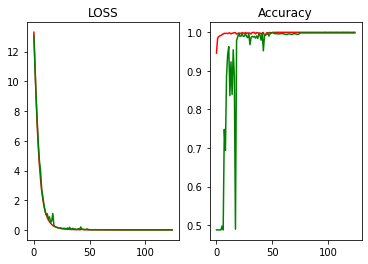

In [13]:
loss = []
val_loss = []
acc = []
val_acc = []
for tr in train.values():
  print(tr)
  loss.extend(tr.history['loss'])
  val_loss.extend(tr.history['val_loss'])
  acc.extend(tr.history['accuracy'])
  val_acc.extend(tr.history['val_accuracy'])

# atvaizduojame grafiskai
plt.subplot(1, 2, 1)
plt.title('LOSS')
plt.plot(loss, color='red')
plt.plot(val_loss, color='green')
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(acc, color='red')
plt.plot(val_acc, color='green')
plt.savefig(path_to_images + "learning_figure.png")

In [14]:
test_generator = DataGenerator(partition['test'], labels, **params)
# įvertiname tikslumą
model.evaluate(test_generator)

18/18 [==============================] - 177s 10s/step - loss: 0.0265 - accuracy: 0.9983


[0.026472166180610657, 0.9982638955116272]

In [15]:
with open(history_path, 'wb') as handle:
    pickle.dump([loss, val_loss, acc, val_acc], handle)

In [16]:
# drive.flush_and_unmount()